In [74]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
fig_path      = '../figures/'
data_path     = '../data/'

In [75]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd 
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker
from proj_utils import *
from mapping_utils import *
from plotting_utils import *

In [76]:
nao_c = '#dc267f'
eap_c = '#fe6100'

## (1) Load and filter time series 

In [77]:
gsi = xr.open_dataarray(data_path + 'gsi_altimetry_timeseries.nc')
nao = xr.open_dataarray(data_path + 'nao_era5_timeseries.nc')
eap = xr.open_dataarray(data_path + 'eap_era5_timeseries.nc')

In [78]:
# --- Filter the time series with Lanczos bandpass filter ---
gsi_f    = lanczos_bandpass(gsi, low_freq = 12*6, high_freq = 12*11, window = 12) 
gsi_f    = (gsi_f - gsi_f.mean(dim='time'))/gsi_f.std(dim = 'time')

nao_f    = lanczos_bandpass(nao, low_freq = 12*6, high_freq = 12*11, window = 12) 
nao_f    = (nao_f - nao_f.mean(dim='time'))/nao_f.std(dim = 'time')

eap_f    = lanczos_bandpass(eap, low_freq = 12*6, high_freq = 12*11, window = 12) 
eap_f    = (eap_f - eap_f.mean(dim='time'))/eap_f.std(dim = 'time')

In [79]:
# --- Drop nans from filtering ---
gsi_f = gsi_f.dropna(dim='time')
nao_f = nao_f.dropna(dim='time')
eap_f = eap_f.dropna(dim='time')

## (2) Calculate lead/lag relationships and confidence intervals

In [80]:
# --- For the full time series, calculate 10 years of lags in either direction ---
n_lags = 12*10

In [81]:
# --- NAO/GSI Lags --- 
nao_gsi_corrs    = lagged_corr(nao_f, gsi_f, n_lags) # Calculate Lagged Correlations, NAO leads at - lags
nao_gsi_corrs    = np.array(nao_gsi_corrs)           # Convert to array
lci_ng,uci_ng    = get_cis(nao_f, gsi_f, n_lags)     # Calculate confidence intervals

In [82]:
# --- EAP/GSI Lags ---
eap_gsi_corrs    = lagged_corr(eap_f, gsi_f, n_lags) # Calculate Lagged Correlations, EAP leads at - lags
eap_gsi_corrs    = np.array(eap_gsi_corrs)           # Convert to array
lci_eg,uci_eg    = get_cis(eap_f, gsi_f, n_lags)     # Calculate confidence intervals

## (3) Plot lead/lag for full time series

In [83]:
# --- For plotting: Grab indices of points that exceed confidence threshold ---
ix_ng = []
for l in range(len(nao_gsi_corrs)):
        if nao_gsi_corrs[l] > uci_ng[l] or nao_gsi_corrs[l] < lci_ng[l]:
            ix_ng.append(l)

ix_eg = []
for l in range(len(eap_gsi_corrs)):
        if eap_gsi_corrs[l] > uci_eg[l] or eap_gsi_corrs[l] < lci_eg[l]:
            ix_eg.append(l)

In [84]:
# --- Make array of lags for plotting ---
lags_array      = np.arange(-n_lags,n_lags+1)       

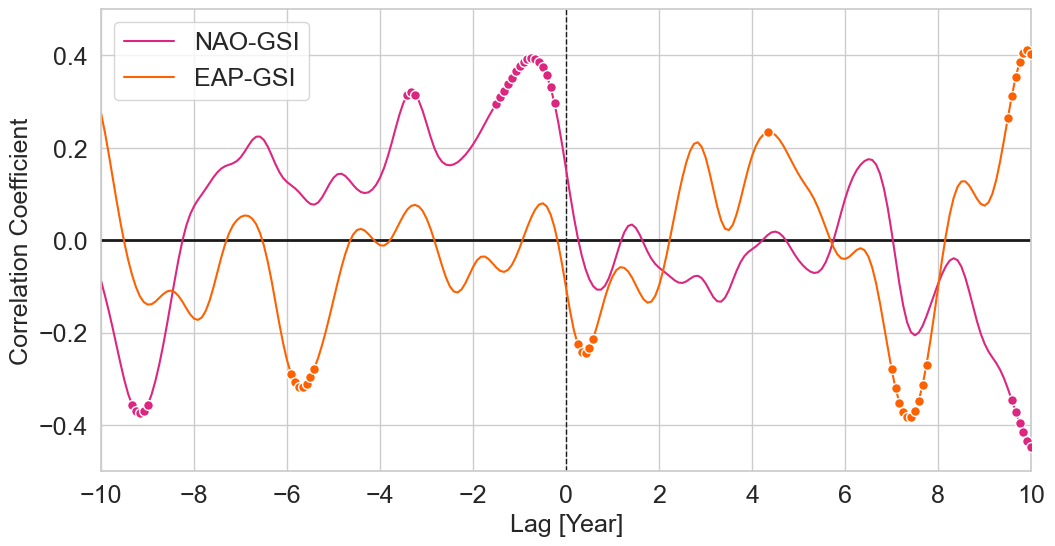

In [89]:
style   = sns.set_style("whitegrid")

fig     = plt.figure(figsize=(12, 6))

zline   = plt.axhline(0, color='k', linewidth=2)
yline   = plt.axvline(0, color='k', linewidth=1, linestyle = '--')

# --- NAO/GSI lead/lag --- 
lags_nao  = plt.plot(lags_array/12,nao_gsi_corrs, c = nao_c, label = 'NAO-GSI')
sigs_nao  = plt.scatter(lags_array[ix_ng]/12, nao_gsi_corrs[ix_ng], s=50, color = nao_c, edgecolors='w',zorder = 10)

# --- EAP/GSI lead/lag --- 
lags_eap  = plt.plot(lags_array/12,eap_gsi_corrs, c = eap_c, label = 'EAP-GSI')
sigs_eao  = plt.scatter(lags_array[ix_eg]/12, eap_gsi_corrs[ix_eg], s=50, color = eap_c, edgecolors='w',zorder = 10)

xtix = plt.yticks(fontsize=18)
ytix = plt.xticks(np.arange(-10,11,2),fontsize=18)
ylab = plt.ylabel('Correlation Coefficient', fontsize = 18)
xlab = plt.xlabel('Lag [Year]',fontsize = 18)
plt.xlim(lags_array[0]/12,lags_array[-1]/12)
plt.ylim(-0.5,0.5)
plt.legend(fontsize = 18)
plt.savefig(fig_path + 'lead_lag_nao_eap_gs_full_ts.png', format='png', bbox_inches="tight",dpi=500)

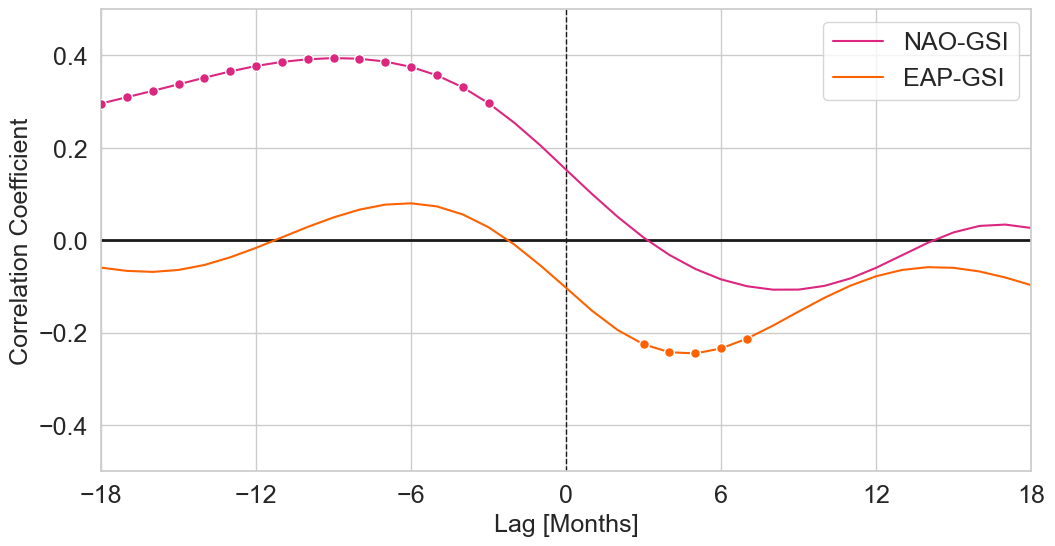

In [86]:
style   = sns.set_style("whitegrid")

fig     = plt.figure(figsize=(12, 6))

zline   = plt.axhline(0, color='k', linewidth=2)
yline   = plt.axvline(0, color='k', linewidth=1, linestyle = '--')

# --- NAO/GSI lead/lag --- 
lags_nao  = plt.plot(lags_array,nao_gsi_corrs, c = nao_c, label = 'NAO-GSI')
sigs_nao  = plt.scatter(lags_array[ix_ng], nao_gsi_corrs[ix_ng], s=50, color = nao_c, edgecolors='w',zorder = 10)

# --- EAP/GSI lead/lag --- 
lags_eap  = plt.plot(lags_array,eap_gsi_corrs, c = eap_c, label = 'EAP-GSI')
sigs_eao  = plt.scatter(lags_array[ix_eg], eap_gsi_corrs[ix_eg], s=50, color = eap_c, edgecolors='w',zorder = 10)

xtix = plt.yticks(fontsize=18)
ytix = plt.xticks(np.arange(-18,19,6),fontsize=18)
ylab = plt.ylabel('Correlation Coefficient', fontsize = 18)
xlab = plt.xlabel('Lag [Months]',fontsize = 18)
plt.xlim(-18,18)
plt.ylim(-0.5,0.5)
plt.legend(fontsize = 18)
plt.savefig(fig_path + 'lead_lag_nao_eap_gs_full_ts_cropped.png', format='png', bbox_inches="tight",dpi=500)

## (4) Calculate lead-lag for each window & plot

In [87]:
window_sz     = 48   # 4 yrs
n_lags        = 18*1
lags_array_wn = np.arange(-n_lags,n_lags+1) 

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for c in range(len(gsi_f)-(window_sz)):
        # --- Slice time series ---
        gsi_temp   = gsi_f.sel(time = slice(gsi_f.time[c].data,gsi_f.time[c+window_sz].data))
        nao_temp   = nao_f.sel(time = slice(nao_f.time[c].data,nao_f.time[c+window_sz].data))
        eap_temp   = eap_f.sel(time = slice(eap_f.time[c].data,eap_f.time[c+window_sz].data))

        # --- NAO/GSI lead/lags ---
        nao_gsi_temp = lagged_corr(nao_temp, gsi_temp, n_lags)                 # Calculate Lagged Correlations
        nao_gsi_temp = np.array(nao_gsi_temp)                                  # Convert to array
        lci_nao_gsi_temp,uci_nao_gsi_temp = get_cis(nao_temp, gsi_temp,n_lags) # Calculate confidence intervals

        ix_nao_gsi_temp = []                                                   # Get sig points
        for l in range(len(nao_gsi_temp)):
                if nao_gsi_temp[l] > uci_nao_gsi_temp[l] or nao_gsi_temp[l] < lci_nao_gsi_temp[l]:
                    ix_nao_gsi_temp.append(l)

        # --- EAP/GSI lead/lags ---
        eap_gsi_temp = lagged_corr(eap_temp, gsi_temp, n_lags)      # Calculate Lagged Correlations
        eap_gsi_temp = np.array(eap_gsi_temp)                       # Convert to array
        lci_eap_gsi_temp,uci_eap_gsi_temp = get_cis(eap_temp, gsi_temp,n_lags)      # Calculate confidence intervals

        ix_eap_gsi_temp = []                                                   # Get sig points
        for l in range(len(eap_gsi_temp)):
                if eap_gsi_temp[l] > uci_eap_gsi_temp[l] or eap_gsi_temp[l] < lci_eap_gsi_temp[l]:
                    ix_eap_gsi_temp.append(l)

        # -----------------------------
        # --- Plot window lead/lags --- 
        # -----------------------------
        style   = sns.set_style("whitegrid")

        fig     = plt.figure(figsize=(12, 6))
        tit     = plt.title(str(gsi_f.time[c].dt.year.data) + '-' + str(gsi_f.time[c].dt.month.data).zfill(2) +  ' to ' + str(gsi_f.time[c + window_sz].dt.year.data) + '-' + str(gsi_f.time[c + window_sz].dt.month.data).zfill(2),fontsize = 16)

        zline   = plt.axhline(0, color='k', linewidth=2)
        yline   = plt.axvline(0, color='k', linewidth=1, linestyle = '--')
        

        # --- NAO/GSI lead/lag WINDOW --- 
        lags_nao  = plt.plot(lags_array_wn,nao_gsi_temp, c = nao_c, label = 'NAO-GSI')
        sigs_nao  = plt.scatter(lags_array_wn[ix_nao_gsi_temp], nao_gsi_temp[ix_nao_gsi_temp], s=50, color = nao_c, edgecolors='w',zorder = 10)
        
        # --- EAP/GSI lead/lag WINDOW --- 
        lags_eap  = plt.plot(lags_array_wn,eap_gsi_temp, c = eap_c, label = 'EAP-GSI')
        sigs_eao  = plt.scatter(lags_array_wn[ix_eap_gsi_temp], eap_gsi_temp[ix_eap_gsi_temp], s=50, color = eap_c, edgecolors='w',zorder = 10)

        # --- NAO/GSI lead/lag FULL TIME SERIES --- 
        lags_nao  = plt.plot(lags_array,nao_gsi_corrs, c = nao_c, alpha = 0.3)
        sigs_nao  = plt.scatter(lags_array[ix_ng], nao_gsi_corrs[ix_ng], s=50, alpha = 0.3, color = nao_c, edgecolors='w',zorder = 10)
        
        # --- EAP/GSI lead/lag FULL TIME SERIES --- 
        lags_eap  = plt.plot(lags_array,eap_gsi_corrs, c = eap_c, alpha = 0.3)
        sigs_eao  = plt.scatter(lags_array[ix_eg], eap_gsi_corrs[ix_eg], s=50, alpha = 0.3, color = eap_c, edgecolors='w',zorder = 10)

        xtix = plt.yticks(fontsize=18)
        ytix = plt.xticks(np.arange(-18,19,6),fontsize=18)
        ylab = plt.ylabel('Correlation Coefficient', fontsize = 18)
        xlab = plt.xlabel('Lag [Months]',fontsize = 18)
        plt.xlim(-18,18)
        plt.ylim(-1,1)
        plt.legend(fontsize = 18, loc = 'upper right')
        plt.savefig(fig_path + 'lead_lags/lead_lag_' + str(gsi_f.time[c].dt.year.data) + str(gsi_f.time[c].dt.month.data).zfill(2) + '.png', format='png', bbox_inches="tight",dpi=500)
        plt.close()

## (5) Save plots as GIF

In [88]:
make_gif_from_folder(fig_path + 'lead_lags', output_path = fig_path + 'lead_lag_all.gif', duration=300)

GIF saved as ../figures/lead_lag_all.gif
